In [43]:
# Setup environment
import os
import glob
import subprocess
import sys
import time
from scipy.io import netcdf as nc

import matplotlib.pyplot as plt
from os.path import expanduser

# Define output path
home = expanduser("~")
output_dir = os.path.join(home,'scratch')  # main output directory.
os.makedirs(os.path.dirname(output_dir), exist_ok=True)
print(output_dir)

/Users/shawnserbin/scratch


In [12]:
# Grab latest CTSM docker container from Docker hub
source = "serbinsh/ctsm_containers"
docker_container_tag = "ctsm-release-clm5.0.15"
container_name = ''.join([source,":",docker_container_tag])
print(container_name)
docker_pull_command = ''.join(["docker pull ",source,":",docker_container_tag])
os.system(docker_pull_command)

# you should see docker pull progress in the Jupyter shell

serbinsh/ctsm_containers:ctsm-release-clm5.0.15


0

In [23]:
# Define run parameters for CTSM
start_year = '1998-01-01'  # you need to place this in the single quotations
num_run_years = 2
hostname = "modex"
user = "clmuser"

# Define input/output paths (host:container)
cesm_input_data_paths = "~/Data/cesm_input_data:/data"
output_path = ''.join([output_dir,":/ctsm_output"])
print(output_path)

# Define script to run
ctsm_case_build_script = "/ctsm_run_scripts/create_case_1pt_example_USNR1.sh"

/Users/shawnserbin/scratch:/ctsm_output


In [24]:
# Define case build command
run_command = ''.join(["docker run --hostname=",hostname," --user ",user," -v ", cesm_input_data_paths, " -v ", output_path, " ", container_name, " ", ctsm_case_build_script, " ", "'",start_year.__str__(),"'", " ", num_run_years.__str__()])
print(run_command)


docker run --hostname=modex --user clmuser -v ~/Data/cesm_input_data:/data -v /Users/shawnserbin/scratch:/ctsm_output serbinsh/ctsm_containers:ctsm-release-clm5.0.15 /ctsm_run_scripts/create_case_1pt_example_USNR1.sh '1998-01-01' 2


In [25]:
# Run
start = time.time()
# run the docker container
os.system(run_command)
# get runtime
end = time.time()
#Print runtime
print(end - start)

149.89844298362732


In [26]:
# Setup run case run command
case_directory = "CLM5_1553001861" # need to grab this from the shell
run_command = ''.join(["docker run --hostname=",hostname," --user ",user," -v ", cesm_input_data_paths, " -v ", output_path, " ",container_name, " ","/bin/sh -c 'cd /ctsm_output/",case_directory," && ./case.submit'"])
print(run_command)


docker run --hostname=modex --user clmuser -v ~/Data/cesm_input_data:/data -v /Users/shawnserbin/scratch:/ctsm_output serbinsh/ctsm_containers:ctsm-release-clm5.0.15 /bin/sh -c 'cd /ctsm_output/CLM5_1553001861 && ./case.submit'


In [27]:
# Run
start = time.time()
# run the docker container
os.system(run_command)
# get runtime
end = time.time()
#Print runtime
print(end - start)

193.58764910697937


In [32]:
# explore output

# first concatenate netCDF files
ncfiles = ''.join([case_directory,".clm2.h0.*"])
print(ncfiles)

concat_command = ''.join(["cd ",output_dir,"/",case_directory,"/run"," && ncrcat ",ncfiles," all_years.nc"])
print(concat_command)
os.system(concat_command)

CLM5_1553001861.clm2.h0.*
cd /Users/shawnserbin/scratch/CLM5_1553001861/run && ncrcat CLM5_1553001861.clm2.h0.* all_years.nc


0

In [36]:
# view output header
ncdump = ''.join(["cd ",output_dir,"/",case_directory,"/run"," && ncdump -h all_years.nc"])
print(ncdump)
os.system(ncdump)

cd /Users/shawnserbin/scratch/CLM5_1553001861/run && ncdump -h all_years.nc


0

In [44]:
# get output
filename_in = ''.join([output_dir,"/",case_directory,"/run/all_years.nc"])
print(filename_in)
fin = nc.netcdf_file(filename_in)


/Users/shawnserbin/scratch/CLM5_1553001861/run/all_years.nc


In [50]:
## read the coordinate data for the various dimensions
time = fin.variables['time'][:]  ### time dimension, put in unit of years
print(time)

[0.0000000e+00 4.1666668e-02 8.3333336e-02 ... 7.2991669e+02 7.2995831e+02
 7.3000000e+02]


In [53]:
# get variables
gpp = fin.variables['GPP'][:]
print(gpp)
lai = fin.variables['TLAI'][:]
print(lai)

[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 ...
 [8.2436854e-06]
 [6.2418949e-06]
 [3.8148587e-06]]
[[0.        ]
 [0.09171552]
 [0.18342568]
 ...
 [0.2747092 ]
 [0.2747124 ]
 [0.27471563]]


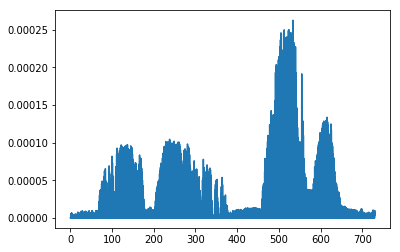

In [55]:
# Plot output
plt.plot(time,gpp, label='GPP')

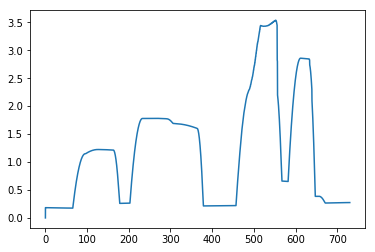

In [56]:
plt.plot(time,lai, label='TLAI')